# **Walmart Store Sales - Forecast**

#### Descrição do Problema

Há estações do ano em que as vendas são significativamente maiores ou menores do que as médias. Se a empresa não souber sobre essas estações, ela pode perder muito dinheiro. A previsão de vendas dá uma ideia para a empresa organizar estoques, calcular receita e decidir fazer um novo investimento.

Um desafio da modelagem de dados de varejo é a necessidade de tomar decisões com base em histórico limitado. Se o Natal acontece apenas uma vez por ano, a chance de ver como as decisões estratégicas impactaram o resultado final também diminui.

Neste conjunto de dados a um historico de vendas de 45 lojas Walmart localizadas em diferentes regiões. Cada loja contém muitos departamentos.

#### Objetivo do Projeto

O objetivo é projetar as vendas de cada departamento em cada loja para os próximos 3 meses.

-------------------------------------------------------------------------------------------------

Desenvolvendo o projeto percebi que algumas variáveis são circunstanciais e não teremos essas informações com precisão para gerar um relatório de vendas para os próximos 3 meses. Sendo assim, decidi removê-las do treinamento do modelo.

- Temperature
- Fuel_Price
- MarkDown's
- CPI
- Unemployment

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import openpyxl

pd.set_option('display.max_columns', None)

from statsmodels.tsa.stattools import kpss
import statsmodels.api as sm

from sklearn.model_selection import TimeSeriesSplit
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
from xgboost import XGBRegressor, plot_importance
import lightgbm as lgb
from lightgbm import LGBMRegressor, plot_importance
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
import optuna


import warnings
warnings.filterwarnings('ignore')

In [3]:
train = pd.read_csv('../data/raw/train.csv')
stores = pd.read_csv('../data/raw/stores.csv')
features = pd.read_csv('../data/raw/features.csv')

display(train.head())
display(stores.head())
display(features.head())

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [4]:
print('Shape dos dados de Treino:', train.shape)
print('Shape dos dados das Lojas:', stores.shape)
print('Shape das features:', features.shape)

Shape dos dados de Treino: (421570, 5)
Shape dos dados das Lojas: (45, 3)
Shape das features: (8190, 12)


- Vou unificar os datasets para uma melhor compreensão e análise.

In [5]:
df = pd.merge(train, features, how='inner', on=['Date', 'Store']).merge(stores, how='inner', on='Store')
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,A,151315


In [6]:
# Removendo as colunas "circunstâncias"
cols_to_drop = ['Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'IsHoliday_y']
df.drop(cols_to_drop, axis=1, inplace=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday_x   421570 non-null  bool   
 5   Type          421570 non-null  object 
 6   Size          421570 non-null  int64  
dtypes: bool(1), float64(1), int64(3), object(2)
memory usage: 19.7+ MB


In [8]:
# Ajuste no tipo de dado da Data e Ajuste na variável IsHoliday
df['Date'] = pd.to_datetime(df['Date'])
df.rename(columns={'IsHoliday_x': 'IsHoliday'}, inplace=True)
df['IsHoliday'] = df['IsHoliday'].astype('int8')

In [9]:
# Verificando se há dados duplicado na base
df.duplicated().sum()

np.int64(0)

In [10]:
# Verificando os dados ausentes
df.isnull().sum().sort_values(ascending=False) / len(df) * 100

Store           0.0
Dept            0.0
Date            0.0
Weekly_Sales    0.0
IsHoliday       0.0
Type            0.0
Size            0.0
dtype: float64

### Análise Exploratória

#### Variável Target (Weekly_Sales)

In [11]:
df[['Weekly_Sales']].describe()

,Weekly_Sales
count,421570.000000
mean,15981.258123
std,22711.183519
min,-4988.940000
25%,2079.650000
50%,7612.030000
75%,20205.852500
max,693099.360000


- Há valores menores do que 0, o que não faz sentido.

In [12]:
df[(df['Weekly_Sales'] < 0) | (df['Weekly_Sales'] == 0)].shape[0] / len(df) * 100

0.3221291837654482

- Vendas com valores menores ou igual a 0 representam 0.3% da base. Vou removê-las!

In [13]:
df = df[(df['Weekly_Sales'] > 0) & (df['Weekly_Sales'] != 0)]

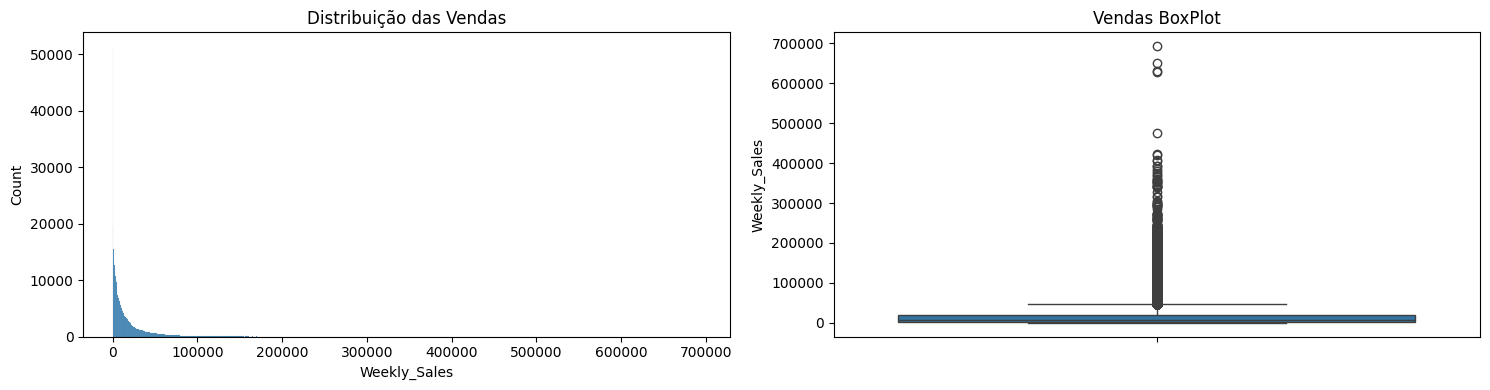

In [14]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (15, 4))

sns.histplot(df['Weekly_Sales'], kde = False, ax = ax1)
ax1.set_title('Distribuição das Vendas')

sns.boxplot(df['Weekly_Sales'], ax = ax2)
ax2.set_title('Vendas BoxPlot')

plt.tight_layout()
plt.show()


Podemos observar bastante valores acima da média e da mediana, com a cauda da distribuição bem forte a direita. Pode ser necessário alguns ajustes para trazer um bom desempenho para o Modelo de Machine Learning.

In [15]:
df[['Weekly_Sales']].describe(percentiles=[.75, .80, .85, .90, .95, .97, .98, .99])

,Weekly_Sales
count,420212.000000
mean,16033.114591
std,22729.492116
min,0.010000
50%,7661.700000
75%,20271.265000
80%,25301.450000
85%,32568.803000
90%,42922.748000
95%,61275.522000


In [16]:
# Vou remover os valores acima do percentil 98.
df = df[df['Weekly_Sales'] < df['Weekly_Sales'].quantile(q = 0.98)]

In [17]:
PALETA = sns.color_palette()
BLUE = PALETA[0]
ORANGE = PALETA[1]

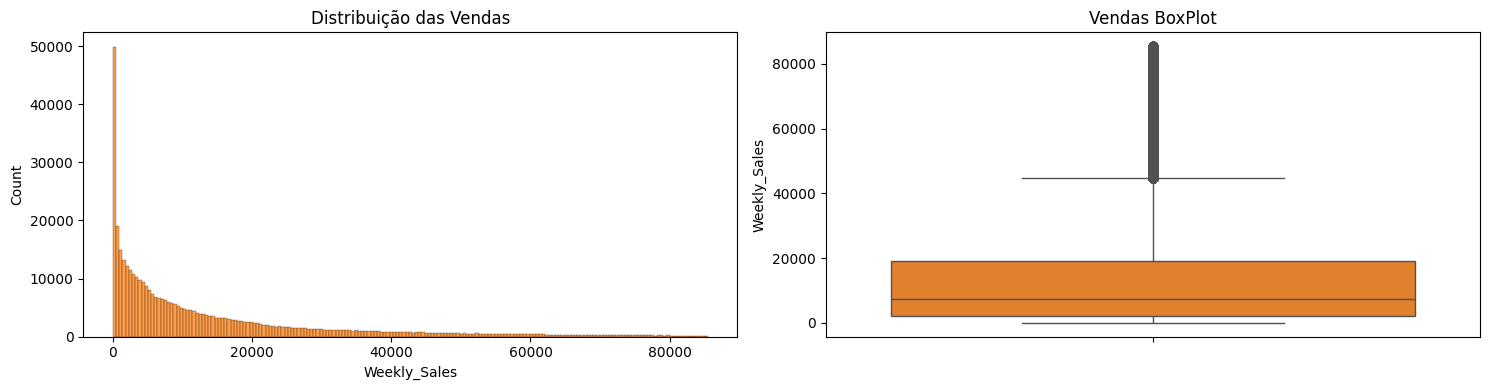

In [18]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (15, 4))

sns.histplot(df['Weekly_Sales'], kde = False, ax = ax1, color=ORANGE)
ax1.set_title('Distribuição das Vendas')

sns.boxplot(df['Weekly_Sales'], ax = ax2, color=ORANGE)
ax2.set_title('Vendas BoxPlot')

plt.tight_layout()
plt.show()

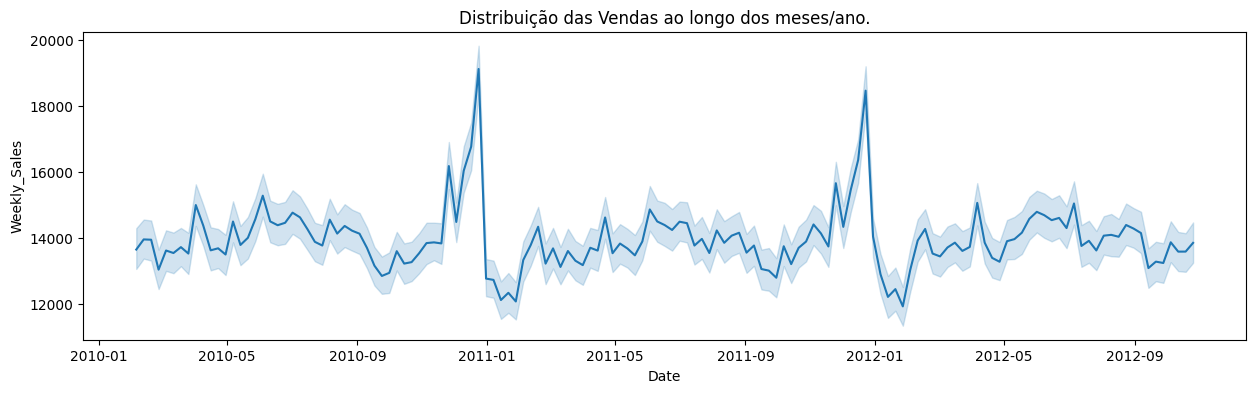

In [19]:
plt.figure(figsize=(15, 4))

sns.lineplot(data=df, x='Date', y='Weekly_Sales')
plt.title('Distribuição das Vendas ao longo dos meses/ano.')

plt.show()

Vou decompor a série para uma análise mais aprofundada.

<Figure size 640x480 with 0 Axes>

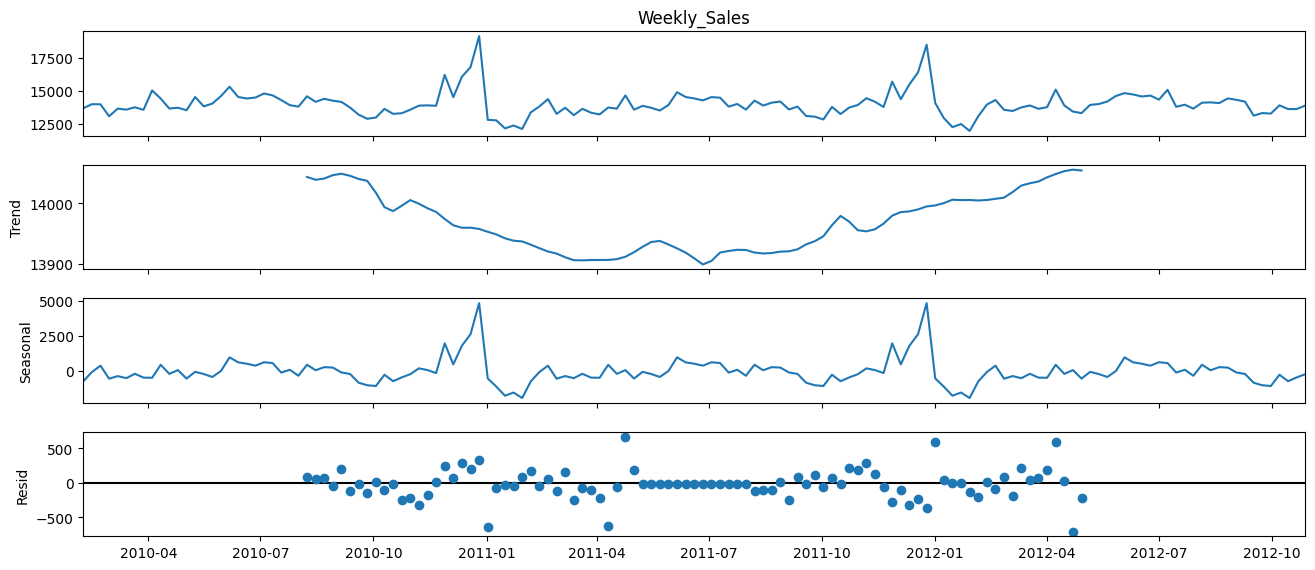

In [20]:
# É necessario fazer o resample das vendas por data. Nesse caso tirei a média das vendas 
df_serie = df.copy()
df_serie.set_index('Date', inplace=True)
weekly_avg_sales = df_serie['Weekly_Sales'].resample('W').mean()
ts_decomposition = sm.tsa.seasonal_decompose(weekly_avg_sales, model='additive')

# Plot
fig = plt.figure()  
fig = ts_decomposition.plot()
fig.set_size_inches(15, 6)

Vou verificar se é uma série estacionaria ou não.

In [21]:
resultado_kpss = kpss(df['Weekly_Sales'], regression = "ct")

print(f'Test Statistic: {resultado_kpss[0]}' )
print(f'p-value: {resultado_kpss[1]}')
print('Critical values:')

for key, value in resultado_kpss[3].items():
    
     print(f'\t{key}: {value}')

Test Statistic: 0.15639822278853047
p-value: 0.04133481434289127
Critical values:
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216


Teste KPSS<br>
Ho = é estacionária: estatística do teste <= valor crítico.<br>
Ha = não é estacionária: estatística do teste > valor crítico.

#### Variável Date

Vou decompor a data em:

- Semana
- Mês
- Trimestre
- Ano


In [22]:
df['Week'] = df['Date'].dt.isocalendar().week
df['Month'] = df['Date'].dt.month
df['Quarter'] = df['Date'].dt.quarter
df['Year'] = df['Date'].dt.year

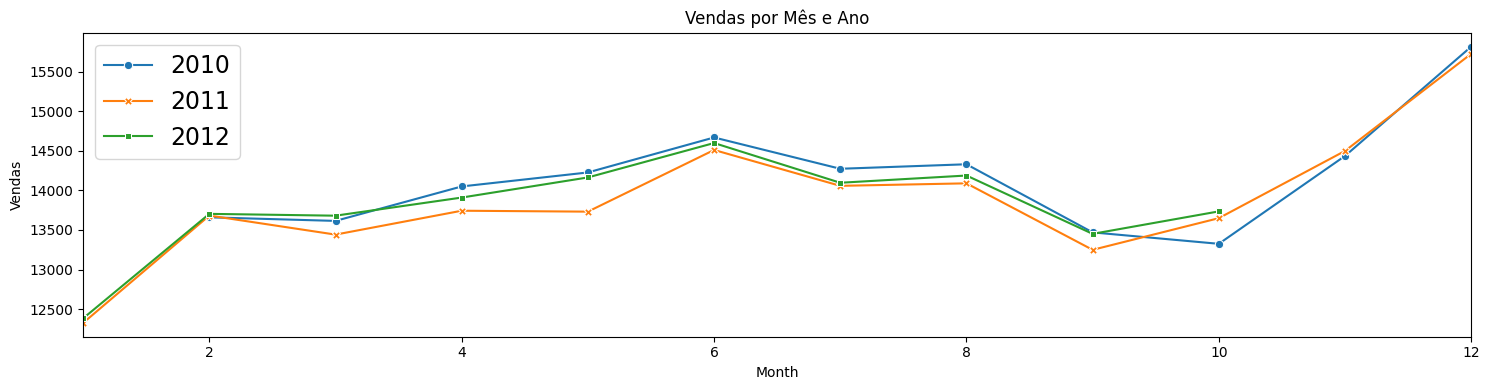

In [23]:
plt.figure(figsize = (15, 4))

sns.lineplot(x='Month', y='Weekly_Sales', data=df, hue='Year', ci=None, palette=PALETA, 
            markers=True, dashes=False, style='Year')

plt.xlim(df['Month'].min(), df['Month'].max())
plt.legend(loc = 2, prop = {'size' : 17}, fontsize = 30)
plt.grid(False)
plt.ylabel('Vendas')
plt.title('Vendas por Mês e Ano')

plt.tight_layout()
plt.show()

- Podemos observar um padrão de vendas em ambos os 3 anos analisados.

#### Variáveis Categóricas

##### IsHoliday

Esses são os feriados que estão na base de dados (nem todos os feriados estão nos dados):

- Super Bowl: 12-fev-10, 11-fev-11, 10-fev-12, 8-fev-13
- Dia do Trabalho: 10-set-10, 9-set-11, 7-set-12, 6-set-13
- Ação de Graças: 26-nov-10, 25-nov-11, 23-nov-12, 29-nov-13
- Natal: 31-dez-10, 30-dez-11, 28-dez-12, 27-dez-13





In [24]:
df['SuperBowl'] = df['Date'].apply(lambda date: 1 if date in [pd.to_datetime('2010-02-12'), 
                                                              pd.to_datetime('2011-02-11'),
                                                              pd.to_datetime('2012-02-10')] else 0)

df['LaborDay'] = df['Date'].apply(lambda date: 1 if date in [pd.to_datetime('2010-09-10'), 
                                                             pd.to_datetime('2011-09-09'),
                                                             pd.to_datetime('2012-09-07')] else 0)

df['Thanksgiving'] = df['Date'].apply(lambda date: 1 if date in [pd.to_datetime('2010-11-26'), 
                                                                 pd.to_datetime('2011-11-25')] else 0)

df['Christmas'] = df['Date'].apply(lambda date: 1 if date in [pd.to_datetime('2010-12-31'), 
                                                              pd.to_datetime('2011-12-30')] else 0)

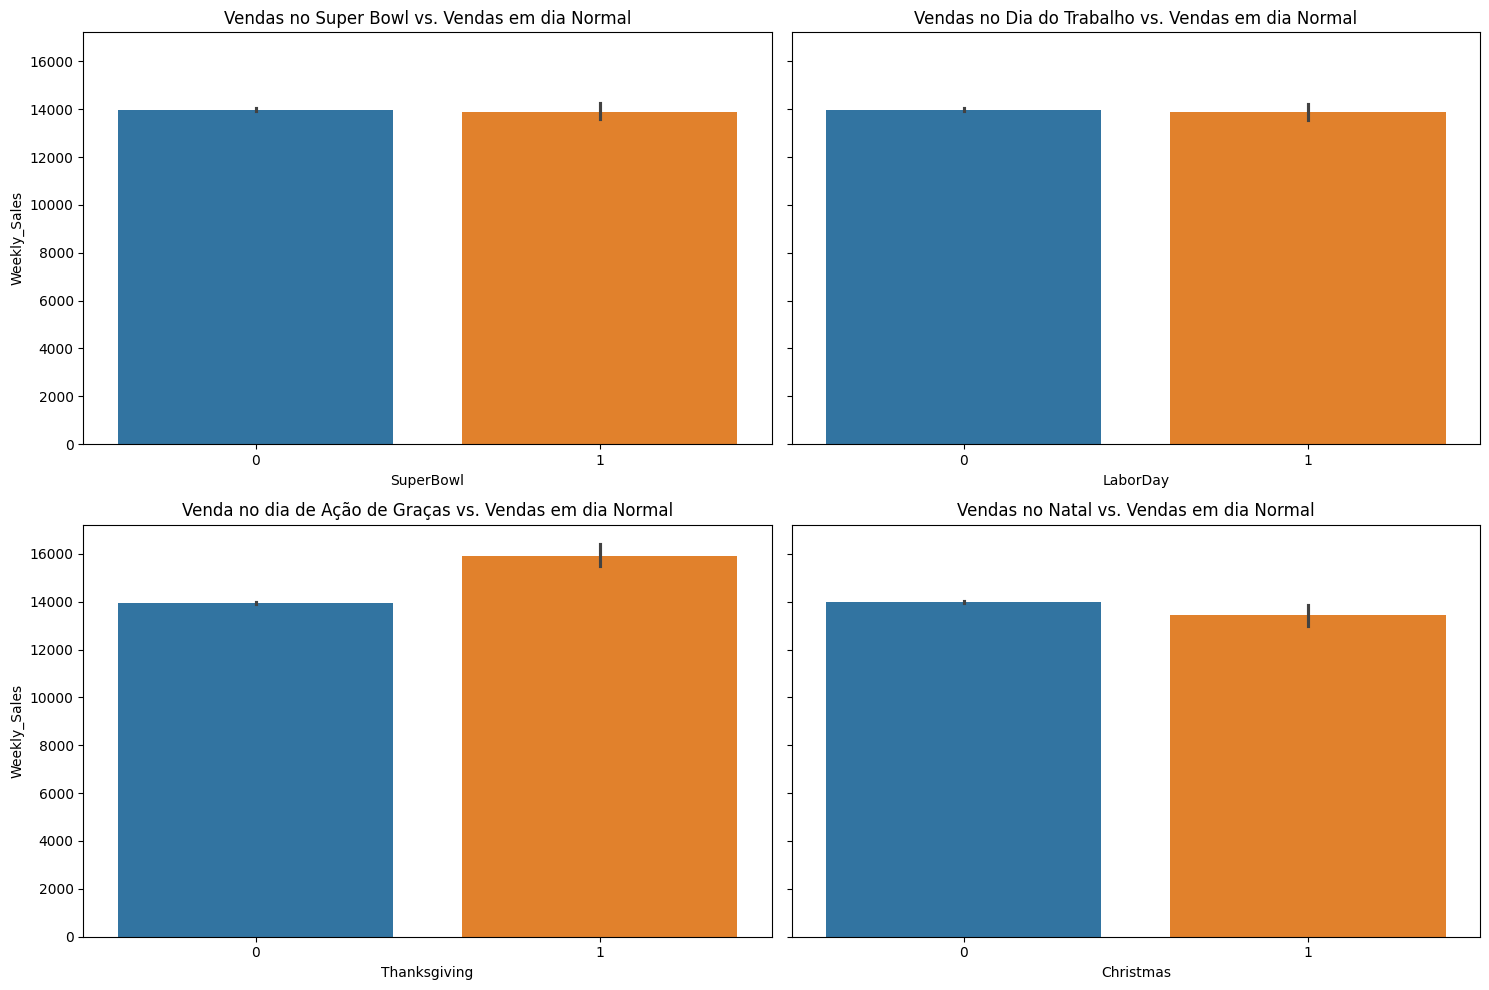

In [25]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols = 2, nrows = 2, sharex = False, sharey = True, figsize = (15, 10))

# SuperBowl ---------------------------------------------------------------

sns.barplot(x='SuperBowl', y='Weekly_Sales', data=df, ax=ax1, palette=PALETA)
ax1.set_title('Vendas no Super Bowl vs. Vendas em dia Normal')

# Dia do Trabalho ----------------------------------------------------------

sns.barplot(x='LaborDay', y='Weekly_Sales', data=df, ax=ax2, palette=PALETA)
ax2.set_title('Vendas no Dia do Trabalho vs. Vendas em dia Normal')

# Ação de Graças ------------------------------------------------------------

sns.barplot(x='Thanksgiving', y='Weekly_Sales', data=df, ax=ax3, palette=PALETA)
ax3.set_title('Venda no dia de Ação de Graças vs. Vendas em dia Normal')

# Natal -------------------------------------------------------------------

sns.barplot(x='Christmas', y='Weekly_Sales', data=df, ax=ax4, palette=PALETA)
ax4.set_title('Vendas no Natal vs. Vendas em dia Normal')

plt.tight_layout()
plt.show()

- No feriado de Ação de Graças há um aumento no número de vendas.
- No feriado de Natal há um decrescimo nas vendas.
- Nos feriados do Dia do Trabalho e Super Bowl não existe um padrão.

##### Type

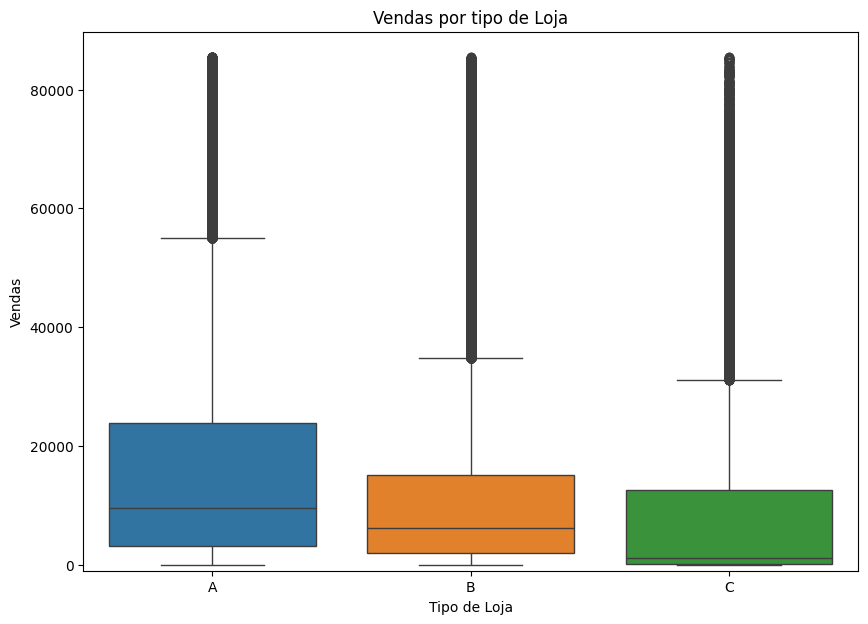

In [26]:
plt.figure(figsize = (10, 7))

sns.boxplot(x='Type', y='Weekly_Sales', data=df, palette=PALETA)

plt.grid(False)
plt.title('Vendas por tipo de Loja')
plt.ylabel('Vendas')
plt.xlabel('Tipo de Loja')
plt.ylim(df['Weekly_Sales'].min() - 1000)
plt.show()

- Podemos observar que a Loja do tipo A aprensenta uma mediana e média maior no número de vendas.

##### Store

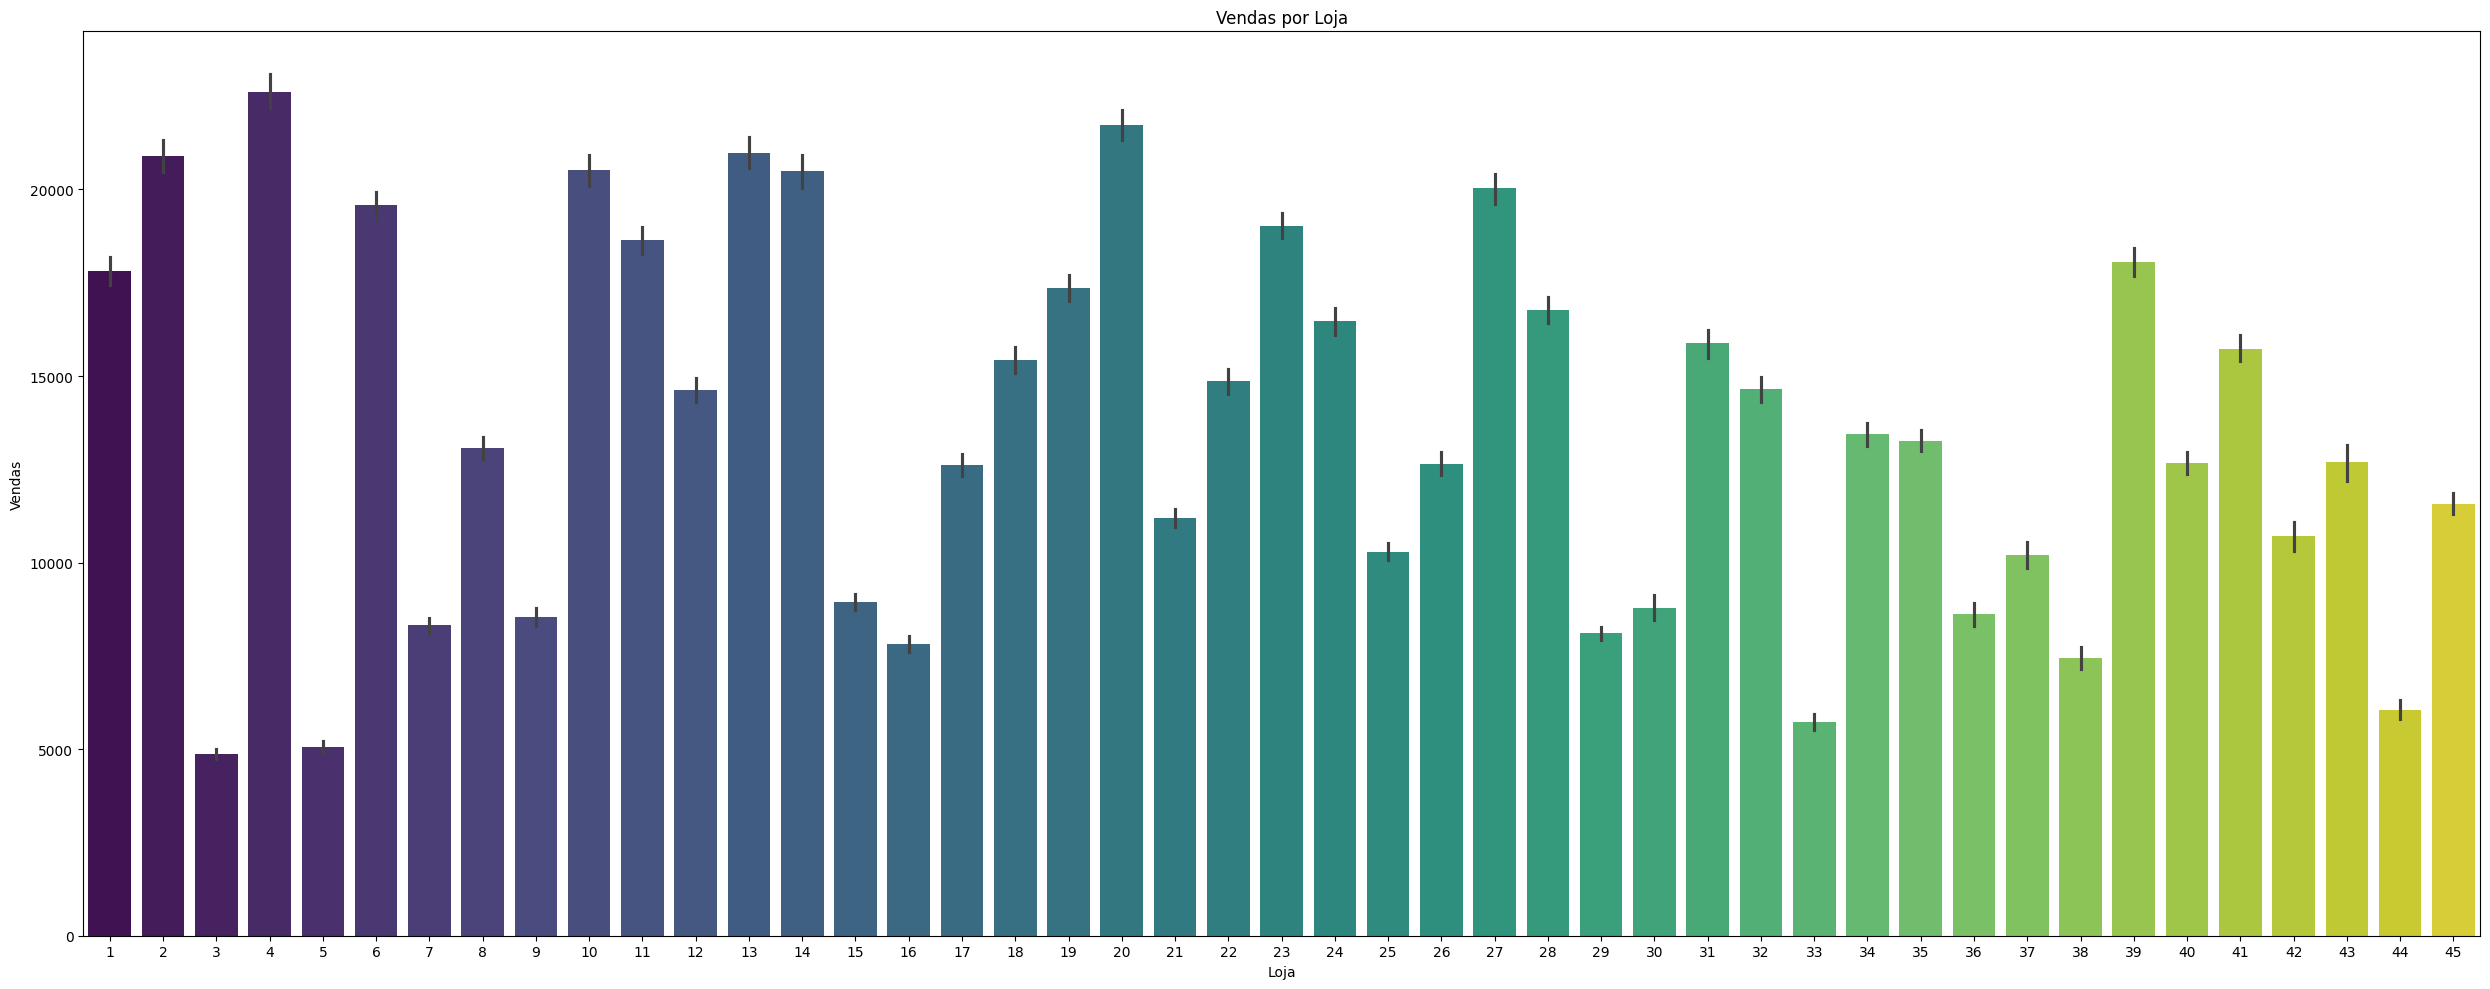

In [27]:
plt.figure(figsize = (25, 10))

sns.barplot(x='Store', y='Weekly_Sales', data=df, palette = 'viridis')
plt.title('Vendas por Loja')
plt.xlabel('Loja')
plt.ylabel('Vendas')

plt.tight_layout()
plt.show()

##### Dept

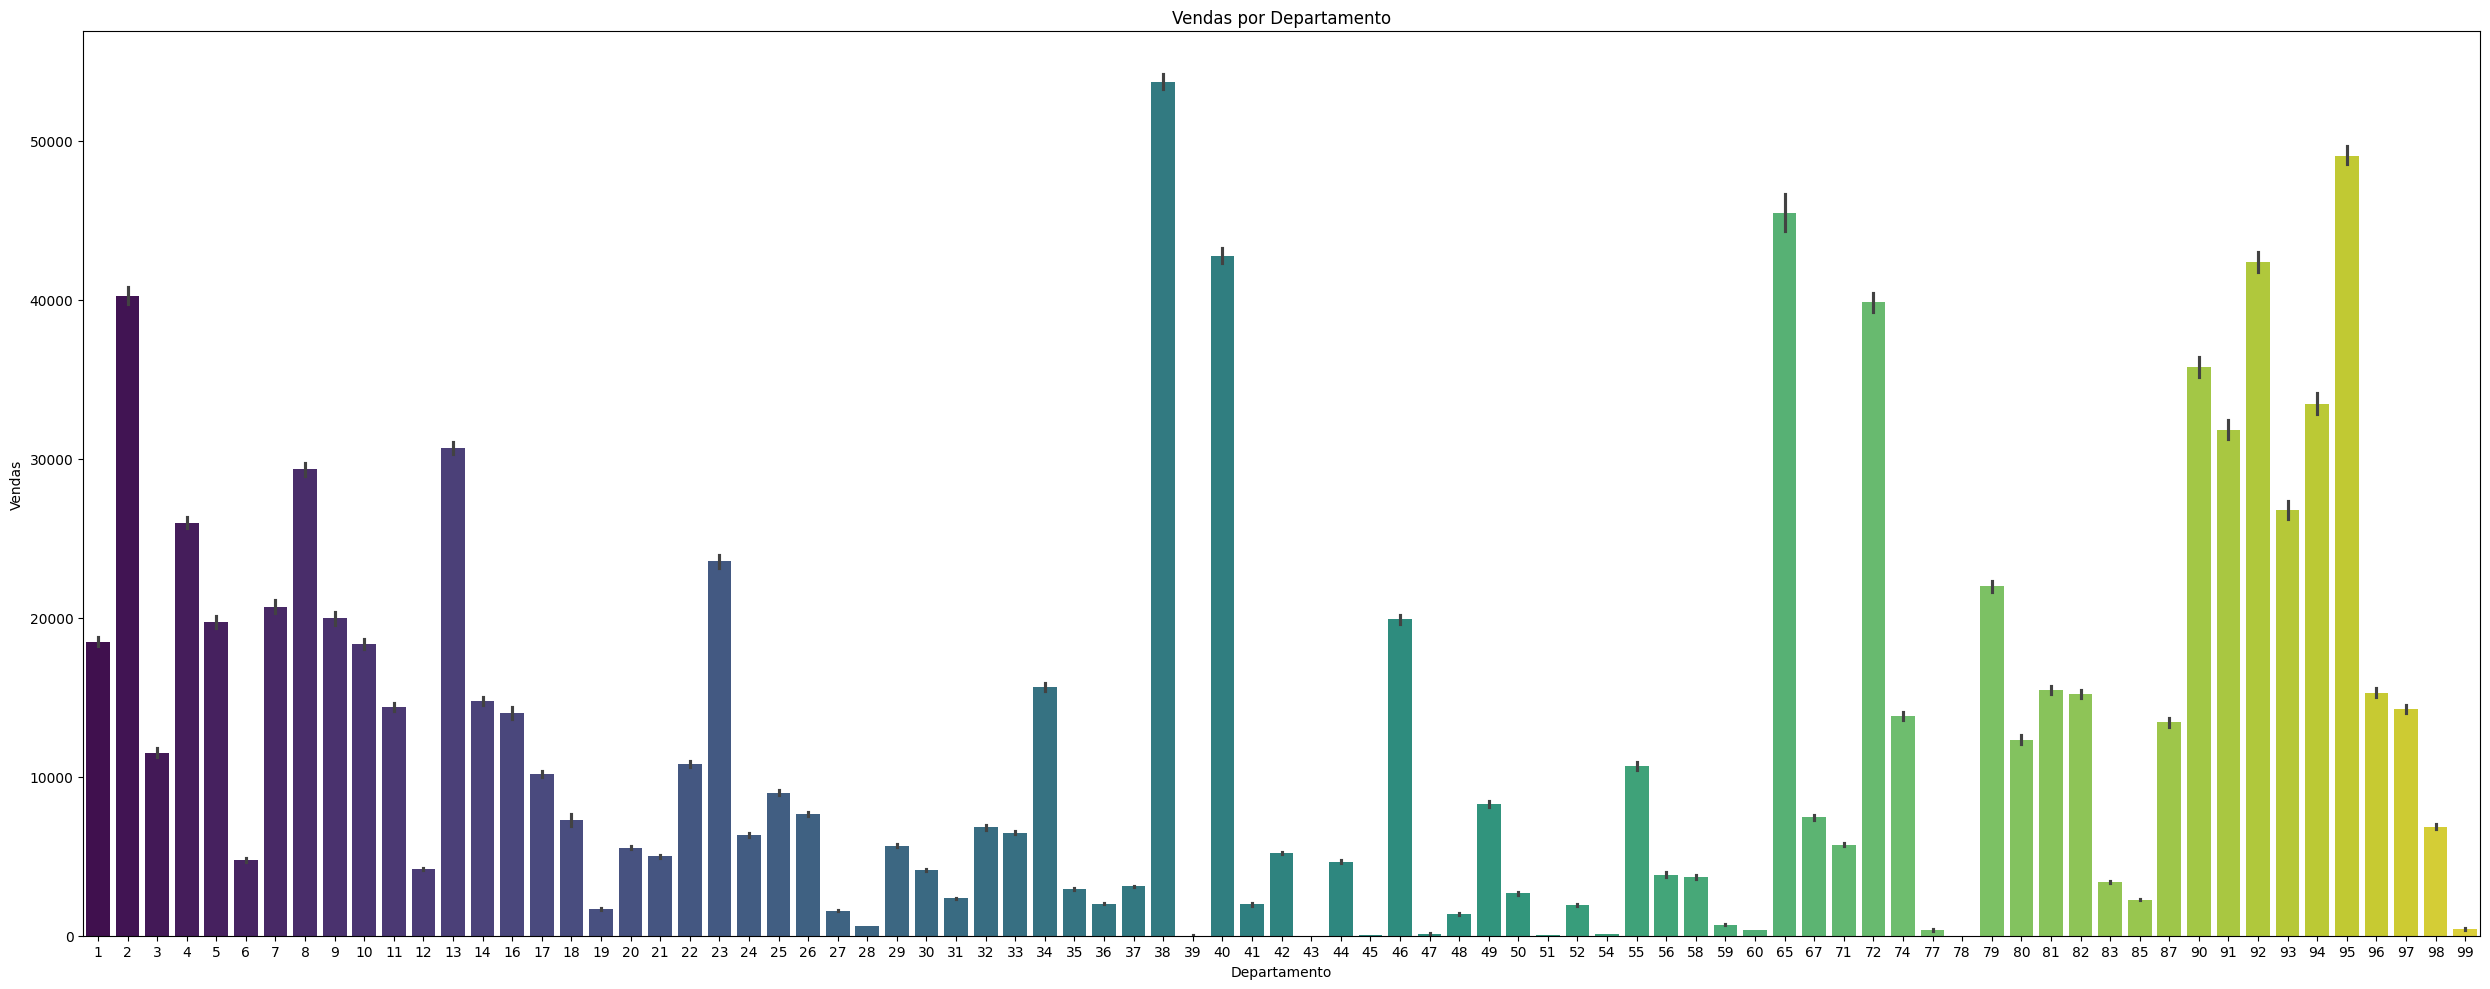

In [28]:
plt.figure(figsize = (25, 10))

sns.barplot(x='Dept', y='Weekly_Sales', data=df, palette='viridis')
plt.title('Vendas por Departamento')
plt.xlabel('Departamento')
plt.ylabel('Vendas')

plt.tight_layout()
plt.show()

### Feature Engineering

In [29]:
df = pd.get_dummies(df, columns=['Type'], dtype='int')

In [30]:
cols_to_drop = ['IsHoliday', 'Year']
df.drop(cols_to_drop, axis=1, inplace=True)

In [31]:
df.set_index('Date', inplace=True)
df.sort_values(by=['Date', 'Store', 'Dept'], inplace=True)

### Time Series Treino-Teste Split

In [32]:
def time_series_split(data, cutoff_date):

    train = data.loc[data.index < cutoff_date]
    test = data.loc[data.index >= cutoff_date]
    return train, test

In [33]:
CUTOFF_DATE = '2012-07-20'
train, test = time_series_split(df, CUTOFF_DATE)
print(f'Shape do Train: {train.shape}. Começa {train.index.min()} termina {train.index.max()}.')
print(f'Shape do Teste: {test.shape}. Começa {test.index.min()} termina {test.index.max()}.')

Shape do Train: (368328, 14). Começa 2010-02-05 00:00:00 termina 2012-07-13 00:00:00.
Shape do Teste: (43479, 14). Começa 2012-07-20 00:00:00 termina 2012-10-26 00:00:00.


In [34]:
def plot_time_series_split(train, test, cutoff_date):
    fig, ax = plt.subplots(figsize=(20, 7))

    # Plot
    sns.lineplot(data=train, x='Date', y='Weekly_Sales', ax=ax, label='Dados de Treino', color=BLUE)
    sns.lineplot(data=test, x='Date', y='Weekly_Sales', ax=ax, label='Dados de Teste', color=ORANGE)
    ax.axvline(cutoff_date, color='black', ls='--', label='Data de Corte')

    # Customização do titulo e dos labels
    plt.title('Time Series Treino-Teste Split', fontsize=20, fontweight='bold')
    plt.xlabel('Data')
    plt.ylabel('Vendas')
    
    # Legenda
    plt.legend()
    plt.show()

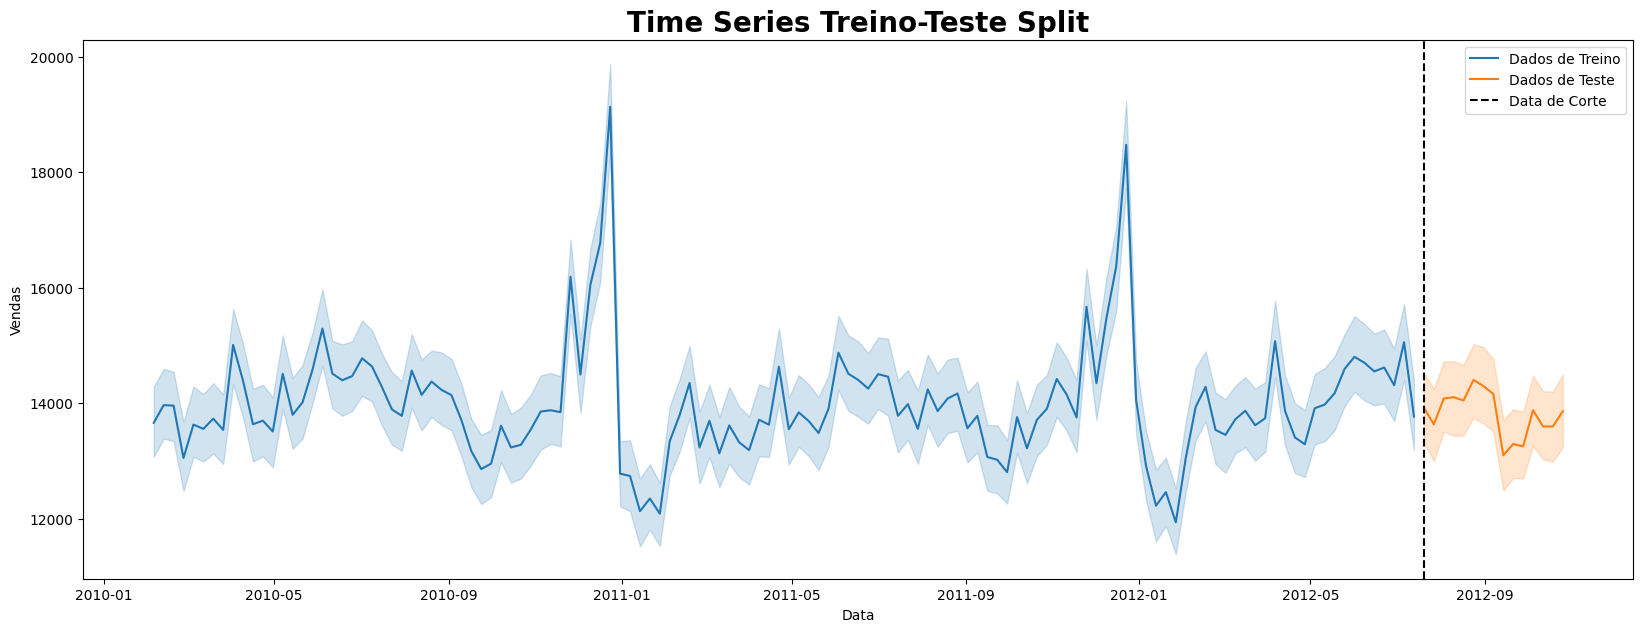

In [35]:
plot_time_series_split(train, test, CUTOFF_DATE)

### Validação Cruzada

In [36]:
def time_series_cv_report(data, target, test_size=None, gap=0, n_splits=5):
    # Get sklearn TimeSeriesSplit object to obtain train and validation chronological indexes at each fold.
    tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_size, gap=gap)

    fig, axes = plt.subplots(n_splits, 1, figsize=(20, 8), sharex=True, sharey=True)

    for fold, (train_index, val_index) in enumerate(tscv.split(data)):
        # Print train and validation indexes at each fold.
        print('-'*30)
        print(f'Fold {fold}')
        print(f'Train: {train_index[0]} to {train_index[-1]}')
        print(f'Validation: {val_index[0]} to {val_index[-1]}')

        # Plot the Time Series Split at each fold.
        axes[fold].plot(data.index, data[target], label='Complete Data', color='green')
        axes[fold].plot(data.iloc[train_index].index, data[target].iloc[train_index], label='Train')
        axes[fold].plot(data.iloc[val_index].index, data[target].iloc[val_index], label='Validation')
        
        axes[fold].set_title(f'Fold {fold} Time Series Split')
        axes[fold].legend(loc='upper left')

    plt.tight_layout()
    plt.show()

------------------------------
Fold 0
Train: 0 to 326867
Validation: 326868 to 335159
------------------------------
Fold 1
Train: 0 to 335159
Validation: 335160 to 343451
------------------------------
Fold 2
Train: 0 to 343451
Validation: 343452 to 351743
------------------------------
Fold 3
Train: 0 to 351743
Validation: 351744 to 360035
------------------------------
Fold 4
Train: 0 to 360035
Validation: 360036 to 368327


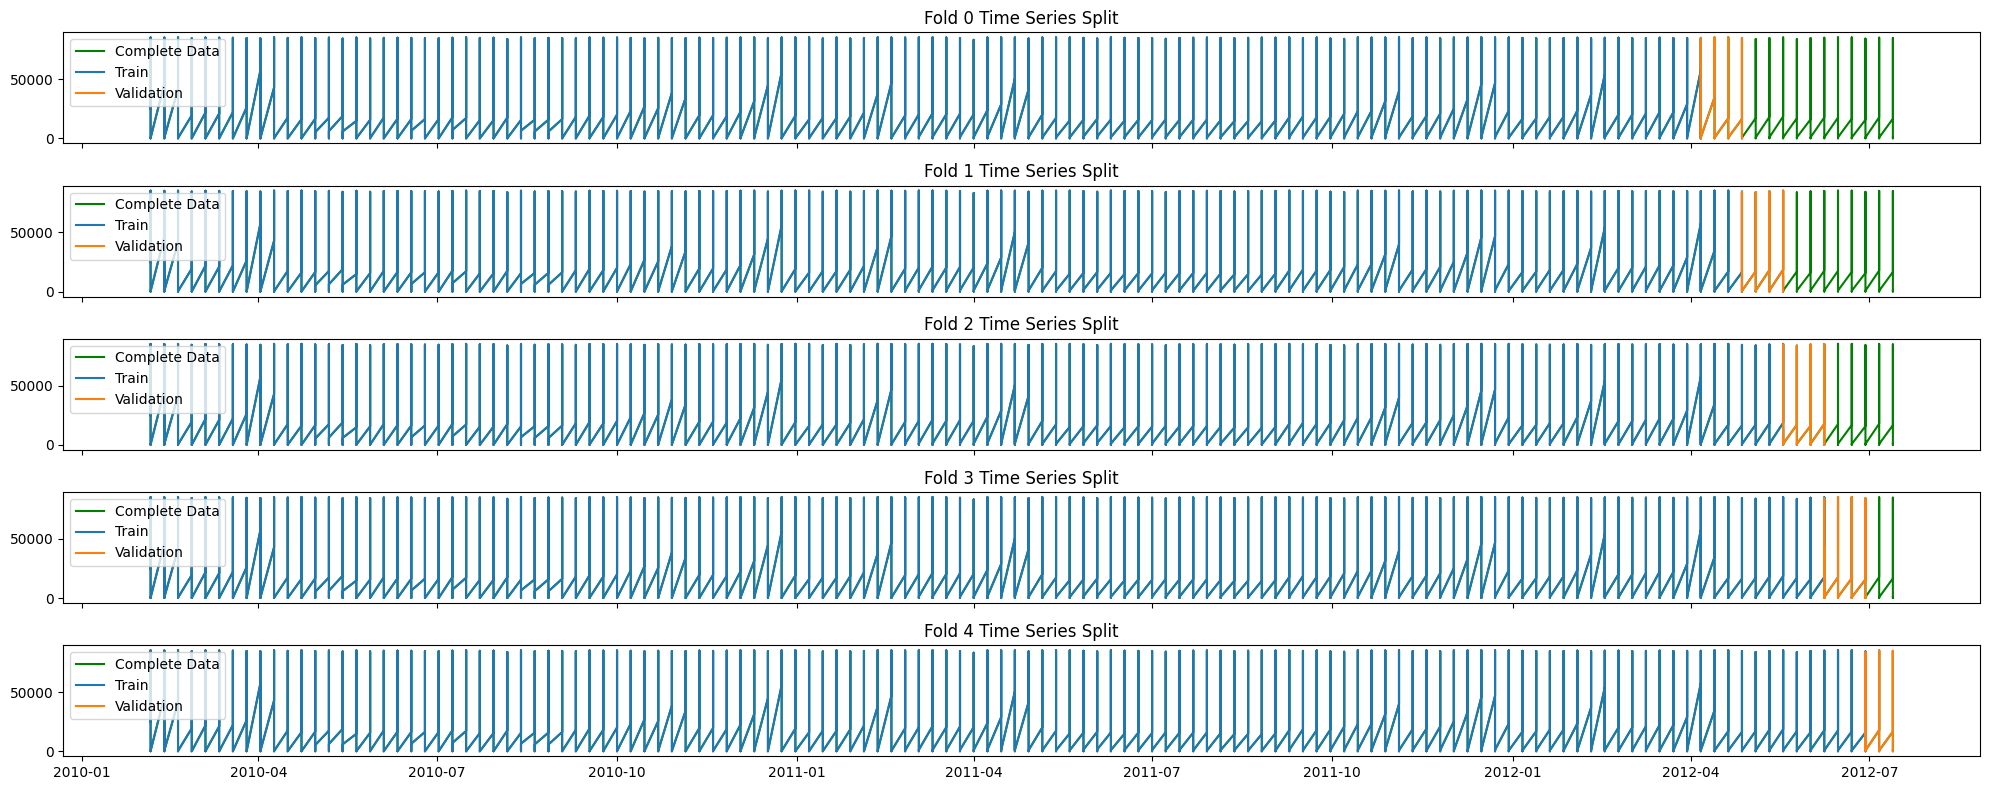

In [37]:
TEST_SIZE, TARGET = 8292, 'Weekly_Sales'
time_series_cv_report(train,  target=TARGET, test_size=TEST_SIZE, n_splits=5)

### Modelagem Machine Learning 

In [38]:
def time_series_cv(data, model, target, test_size=None, gap=0, n_splits=5, log=False, verbose=False, display_score=True):
    # Get sklearn TimeSeriesSplit object to obtain train and validation chronological indexes at each fold.
    tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_size, gap=gap)

    scores = []
    for fold, (train_index, val_index) in enumerate(tscv.split(data)):
        # Obtain train and validation data at fold k.
        train = data.iloc[train_index]
        val = data.iloc[val_index]

        # Obtain predictor and target train and validation sets.
        X_train = train.drop(columns=[target])
        y_train = train[target].copy()
        X_val = val.drop(columns=[target])
        y_val = val[target].copy()

        # Fit the model to the training data.
        model.fit(X_train, y_train)

        # Predict on validation data.
        y_pred = model.predict(X_val)

        # Obtain the validation score at fold k.
        if log:
            score = np.sqrt(mean_squared_error(np.expm1(y_val), np.expm1(y_pred)))
        else:
            score = np.sqrt(mean_squared_error(y_val, y_pred))
        
        scores.append(score)

        # Print the results and returning scores array.

        if verbose:
            print('-'*40)
            print(f'Fold {fold}')
            print(f'Score (RMSE) = {round(score, 4)}')
    
    if not display_score:
        return scores
    
    print('-'*60)
    print(f"{type(model).__name__}'s time series cross validation results:")
    print(f'RMSE Média nos dados de validação = {round(np.mean(scores), 4)}')
    print(f'Desvio Padrão = {round(np.std(scores), 4)}')

    return scores

#### Dados Normais

In [39]:
# Divisão Treino e Teste
train, test = time_series_split(df, CUTOFF_DATE)
scores = time_series_cv(train, DummyRegressor(strategy='mean'), TARGET, TEST_SIZE, n_splits=5)

------------------------------------------------------------
DummyRegressor's time series cross validation results:
RMSE Média nos dados de validação = 17298.1176
Desvio Padrão = 323.935


In [40]:
# Treinamento Teste e Validação
scores = time_series_cv(train, RandomForestRegressor(), TARGET, TEST_SIZE, n_splits=5)

------------------------------------------------------------
RandomForestRegressor's time series cross validation results:
RMSE Média nos dados de validação = 3266.9722
Desvio Padrão = 306.1353


In [41]:
# Treinamento Teste e Validação
scores = time_series_cv(train, GradientBoostingRegressor(), TARGET, TEST_SIZE, n_splits=5)

------------------------------------------------------------
GradientBoostingRegressor's time series cross validation results:
RMSE Média nos dados de validação = 9380.2304
Desvio Padrão = 323.0523


In [42]:
# Treinamento Teste e Validação
scores = time_series_cv(train, XGBRegressor(n_jobs=-1), TARGET, TEST_SIZE, n_splits=5)

------------------------------------------------------------
XGBRegressor's time series cross validation results:
RMSE Média nos dados de validação = 4407.7196
Desvio Padrão = 300.1055


In [43]:
# Treinamento Teste e Validação
scores = time_series_cv(train, LGBMRegressor(n_jobs=-1, verbose=-1), TARGET, TEST_SIZE, n_splits=5)

------------------------------------------------------------
LGBMRegressor's time series cross validation results:
RMSE Média nos dados de validação = 5697.4769
Desvio Padrão = 348.3836


#### Aplicando a Transformação Logarítmica (log1p)

In [44]:
df_log = df.copy()
df_log['Weekly_Sales'] = np.log1p(df_log['Weekly_Sales'])

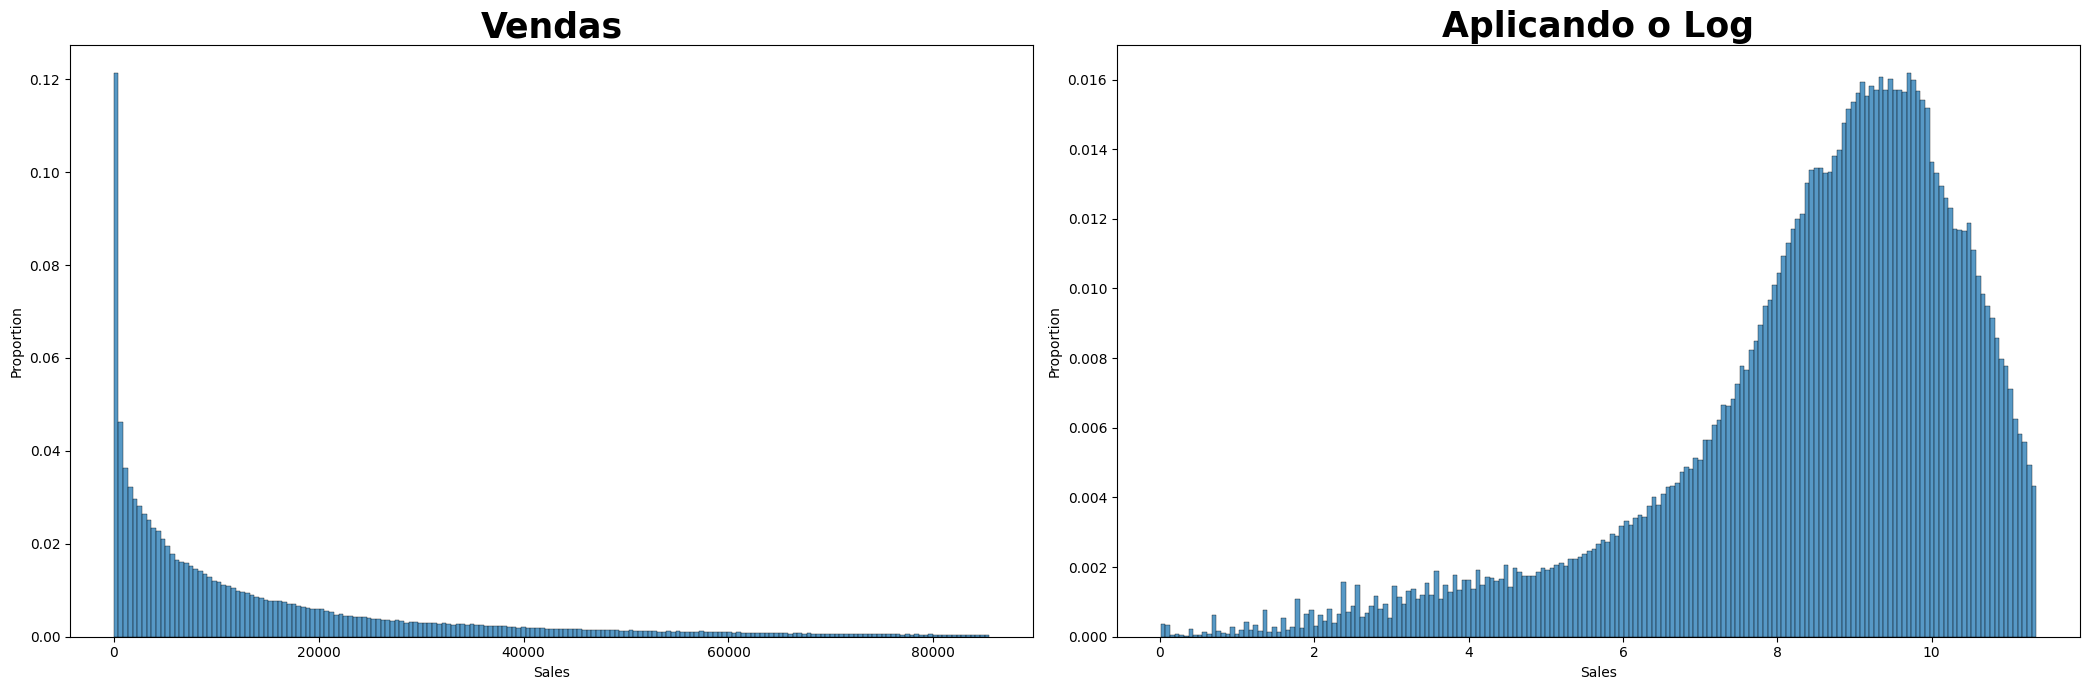

In [45]:
fig, ax = plt.subplots(1, 2, figsize=(21, 7))

ax0 = sns.histplot(data=df, x='Weekly_Sales', ax=ax[0], stat='proportion')
ax0.set_title('Vendas', fontsize=25, fontweight='bold')
ax0.set_xlabel('Sales')

ax1 = sns.histplot(data=df_log, x='Weekly_Sales', ax=ax[1], stat='proportion')
ax1.set_title('Aplicando o Log', fontsize=25, fontweight='bold')
ax1.set_xlabel('Sales')

plt.tight_layout()
plt.show()

In [46]:
train_log, test_log = time_series_split(df_log, CUTOFF_DATE)
scores = time_series_cv(train_log, RandomForestRegressor(), TARGET, TEST_SIZE, n_splits=5, log=True)

------------------------------------------------------------
RandomForestRegressor's time series cross validation results:
RMSE Média nos dados de validação = 3230.3114
Desvio Padrão = 256.7655


In [47]:
scores = time_series_cv(train_log, GradientBoostingRegressor(), TARGET, TEST_SIZE, n_splits=5, log=True)

------------------------------------------------------------
GradientBoostingRegressor's time series cross validation results:
RMSE Média nos dados de validação = 12578.4834
Desvio Padrão = 404.4604


In [48]:
scores = time_series_cv(train_log, XGBRegressor(n_jobs=-1), TARGET, TEST_SIZE, n_splits=5, log=True)

------------------------------------------------------------
XGBRegressor's time series cross validation results:
RMSE Média nos dados de validação = 5080.324
Desvio Padrão = 275.236


In [49]:
scores = time_series_cv(train_log, LGBMRegressor(verbose=-1, n_jobs=-1), TARGET, TEST_SIZE, n_splits=5, log=True)

------------------------------------------------------------
LGBMRegressor's time series cross validation results:
RMSE Média nos dados de validação = 7816.2202
Desvio Padrão = 431.4873


In [54]:
# Salvando os Datasets prontos.
df_log.to_csv('../data/processed/df_log.csv')
df.to_csv('../data/processed/df_prep.csv')

In [50]:
# Divisão entre as variáveis preditoras e a variável target
train, test = time_series_split(df, CUTOFF_DATE)

X_train = train.drop(columns=['Weekly_Sales'])
y_train = train['Weekly_Sales']
X_test = test.drop(columns=['Weekly_Sales'])
y_test = test['Weekly_Sales']

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(368328, 13) (368328,) (43479, 13) (43479,)


### Otimização dos Hiperparâmetros (Optuna)

O Optuna é uma biblioteca de otimização de hiperparâmetros que utiliza métodos de busca avançados para encontrar os melhores hiperparâmetros para modelos de machine learning. Ele é especialmente útil por ser fácil de usar e permitir a implementação de estratégias de busca eficientes, como o algoritmo de Tree-structured Parzen Estimator (TPE).

Realizei o treinamento com o modelos RandomForest, XGboost e LightGBM. LightGBM apresentou a melhor performance.

In [51]:
# Treinamento LightGBM
def objective(trial):
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'n_estimators': 1000,
        'verbosity': -1,
        'bagging_freq': 1,
        'n_jobs': -1,
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 2**10),
        'subsample': trial.suggest_float('subsample', 0.05, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.05, 1.0),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
    }

    model = LGBMRegressor(**params)
    rmse_scores = time_series_cv(train, model=model, target=TARGET, test_size=TEST_SIZE, 
                                 gap=0, log=False, display_score=False)
    avg_rmse = np.mean(rmse_scores)
    
    return avg_rmse 

In [52]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

[I 2024-10-07 16:28:15,926] A new study created in memory with name: no-name-fcdb3ae9-80ef-41f4-aea6-0efa77a1c283
[I 2024-10-07 16:30:21,774] Trial 0 finished with value: 4176.154932218625 and parameters: {'learning_rate': 0.005218977640919364, 'num_leaves': 523, 'subsample': 0.11665514564629913, 'colsample_bytree': 0.8923754377697704, 'min_data_in_leaf': 52}. Best is trial 0 with value: 4176.154932218625.
[I 2024-10-07 16:31:16,768] Trial 1 finished with value: 5488.742486999456 and parameters: {'learning_rate': 0.006801254821502297, 'num_leaves': 170, 'subsample': 0.9549135742583419, 'colsample_bytree': 0.4088312891253782, 'min_data_in_leaf': 92}. Best is trial 0 with value: 4176.154932218625.
[I 2024-10-07 16:33:14,881] Trial 2 finished with value: 6108.421936163935 and parameters: {'learning_rate': 0.0025128392873426807, 'num_leaves': 457, 'subsample': 0.36869229400359316, 'colsample_bytree': 0.513084315610175, 'min_data_in_leaf': 5}. Best is trial 0 with value: 4176.154932218625.


In [53]:
print(f'Best params found for LightGBM: {study.best_params}')
print(f'Best RMSE = {study.best_value}')

Best params found for LightGBM: {'learning_rate': 0.01158123736336193, 'num_leaves': 639, 'subsample': 0.8115770857665777, 'colsample_bytree': 0.9960901537349851, 'min_data_in_leaf': 13}
Best RMSE = 3184.2182753703737


### Avaliação do Desempenho

In [54]:
best_params = { 'objective': 'regression',
                'metric': 'rmse',
                'n_estimators': 1000,
                'verbosity': -1,
                'bagging_freq': 1,
                'learning_rate': 0.01158123736336193, 
                'num_leaves': 639, 
                'subsample': 0.8115770857665777, 
                'colsample_bytree': 0.9960901537349851, 
                'min_data_in_leaf': 13}
lgb_reg = LGBMRegressor(**best_params, n_jobs=-1)
lgb_reg.fit(X_train, y_train)
y_pred = lgb_reg.predict(X_test)

In [55]:
def plot_predictions(testing_dates, y_test, y_pred):
    df_test = pd.DataFrame({'date': testing_dates, 'real': y_test, 'predito': y_pred })

    fig, ax = plt.subplots(figsize=(20, 7))

    # Plot
    sns.lineplot(ax=ax, data=df_test, x='date', y='real', label='Valor Real', color=BLUE)
    sns.lineplot(ax=ax, data=df_test, x='date', y='predito', label='Valor Previsto', color=ORANGE)
    
    # Titulo e Labels
    plt.title('Real vs Previsto', fontweight='bold', fontsize=25)
    plt.ylabel('Vendas')
    plt.xlabel('Data')

    plt.legend()
    plt.show()

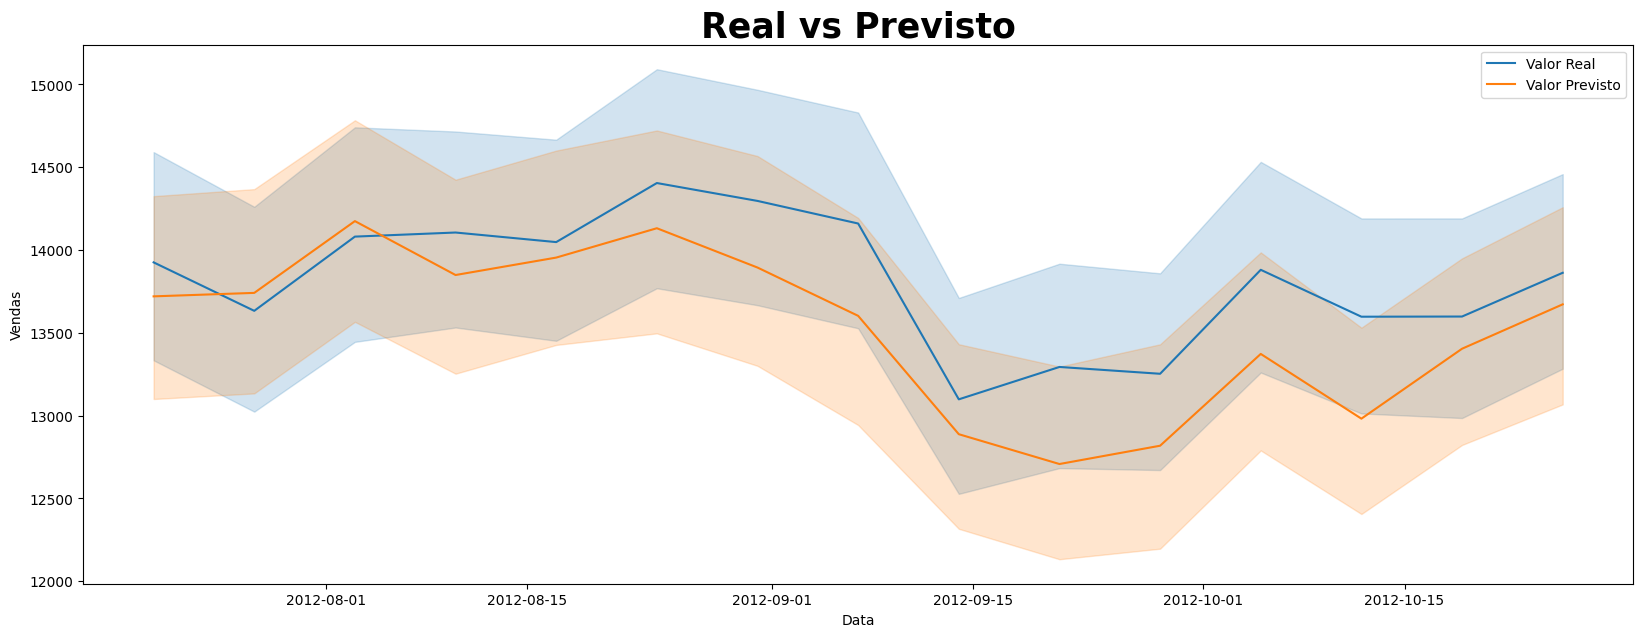

In [56]:
# LightGBM
plot_predictions(X_test.index, y_test, y_pred)

In [57]:
def compare_real_predict(y_true, y_pred):
    df_real_pred = pd.DataFrame({'Real': np.round(y_true, 2),
                                 'Previsto': np.round(y_pred, 2), 
                                 'Residuo': np.round(np.abs(y_pred - y_true), 2)})
    return df_real_pred

In [58]:
# Lightgbm
df_real_pred = compare_real_predict(y_test, y_pred)
df_real_pred

,Real,Previsto,Residuo
Date,,,
2012-07-20,16348.06,15958.67,389.39
2012-07-20,45108.22,45177.68,69.46
2012-07-20,20126.95,18980.16,1146.79
2012-07-20,38080.05,35370.34,2709.71
2012-07-20,17896.46,17926.12,29.66
...,...,...,...
2012-10-26,2487.80,2390.57,97.23
2012-10-26,5203.31,3073.87,2129.44
2012-10-26,56017.47,48559.63,7457.84


In [59]:
# LightGBM
print('Média do valor das vendas:', df_real_pred['Real'].mean().round(2))
print('Média do ERRO do modelo:', df_real_pred['Residuo'].mean().round(2))

Média do valor das vendas: 13815.53
Média do ERRO do modelo: 1631.6


In [60]:
def evaluate_regressor(y_true, y_pred, y_train, model_name):
    mae = round(mean_absolute_error(y_true, y_pred), 4)
    mse = round(mean_squared_error(y_true, y_pred), 4)
    rmse = round(mean_squared_error(y_true, y_pred, squared=False), 4)
    r2 = round(r2_score(y_true, y_pred), 4)
    mape = round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100, 4)
    
    # Metrics
    print(f'Mean Absolute Error (MAE): {mae}')
    print(f'Mean Absolute Percentage Error (MAPE): {mape}')
    print(f'Mean Squared Error (MSE): {mse}')
    print(f'Root Mean Squared Error (RMSE): {rmse}')
    print(f'R-Squared (R2): {r2}')
    
    # Obtain a dataframe of the metrics.
    df_results = pd.DataFrame({'Model': model_name, 'MAE': mae, 'MAPE': mape, 'RMSE': rmse, 'R2': r2}, index=['Results'])

    # Residual Plots
    
    # Analyze the results
    plt.figure(figsize=(5, 3))
    plt.title('Valor Real vs Valor Previsto', fontweight='bold', fontsize=12)
    plt.plot([y_train.min(),y_train.max()],[y_train.min(),y_train.max()], linestyle='--', color='#F26419')
    plt.scatter(y_true, y_pred, color='#233D4D')
    plt.xlabel('Real', fontsize=11)
    plt.ylabel('Previsto', fontsize=11)
    plt.show()
    
    # Distribution of the residuals
    plt.figure(figsize=(5, 3))
    sns.histplot((y_true - y_pred), kde=True)
    plt.title('Distribuicao dos Residuos', fontsize=12, fontweight='bold')
    plt.show()

    return df_results

MAE: 1631.5954
RMSE: 3089.4479
MAPE: 4081.681
R2: 0.9672


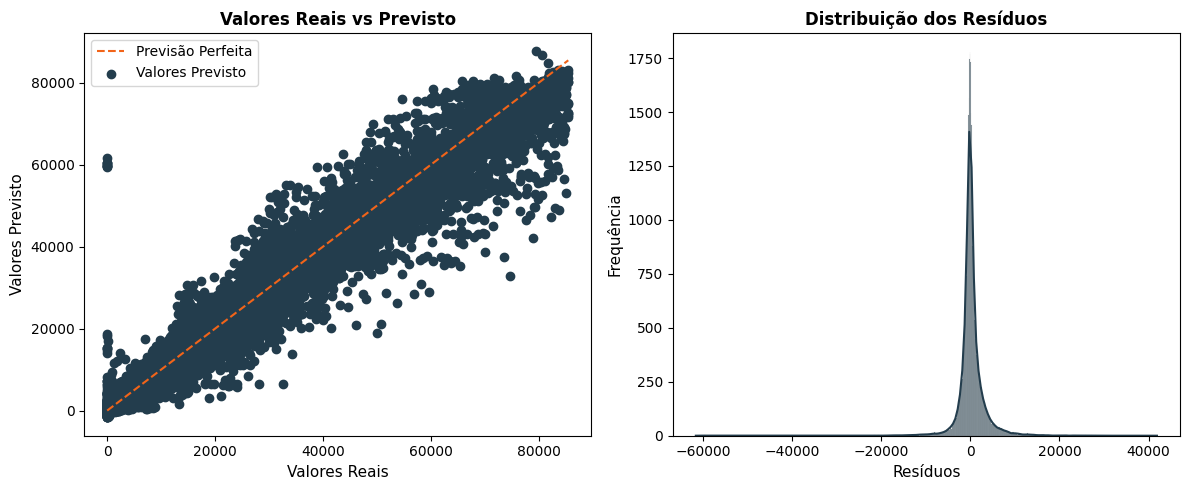

In [96]:
# LightGBM
df_results = evaluate_regressor(y_test, y_pred, y_train, 'LightGBM')

In [97]:
df_results

,MAE,RMSE,MAPE,R2
LightGBM,1631.5954,3089.4479,4081.681,0.9672


1. <b>MAE</b> As previsões do nosso modelo, em média, estão erradas em 1631.59 unidades da variável alvo (vendas).
2. <b>R-quadrado (R2)</b> é uma métrica estatística usada para medir a proporção de variância na variável dependente explicada pela(s) variável(is) independente(s). Ela varia de 0 a 1, onde 0 indica que o modelo não explica nenhuma variância e 1 indica um ajuste perfeito. R2 é comumente usado para avaliar a qualidade do ajuste de um modelo de regressão. De acordo com o R-quadrado, 96,7% da variância na variável dependente é explicada pelo modelo. Muito bom!
3. Os <b>resíduos</b> estão distribuídos normalmente com média zero e sua variância é quase constante.

### Interpretabilidade do Modelo

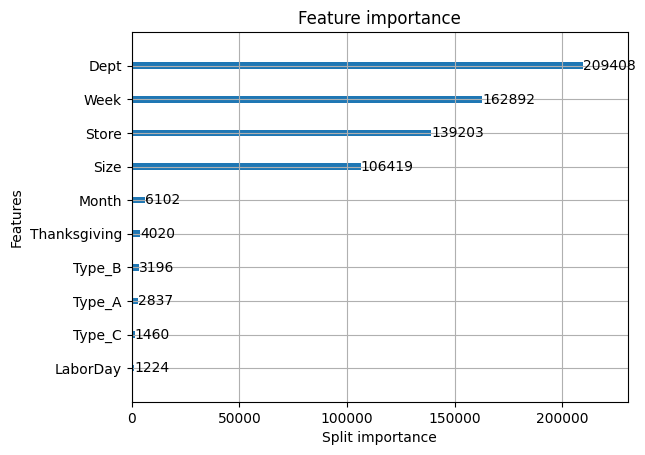

In [63]:
plot_importance(lgb_reg, max_num_features=10, importance_type='split', xlabel='Split importance', ylabel='Features');

### Salvando o Modelo final

In [64]:
def save_object(file_path, object):
    dir_path = os.path.dirname(file_path)
    os.makedirs(dir_path, exist_ok=True)
    
    with open(file_path, 'wb') as file_object:
        pickle.dump(object, file_object)

In [65]:
lgb_reg_path = os.path.join(os.pardir, 'models', 'lgb_reg.pkl')
save_object(lgb_reg_path, lgb_reg)

In [70]:
# Carregando o modelo
#lgb_model = pickle.load(open('../models/lgb_reg.pkl', 'rb'))

### Resultados Financeiros - Dados de Teste

#### LightGBM

In [71]:
financial_results = X_test.copy().reset_index()[['Date', 'Store', 'Dept']]
financial_results['Weekly_Sales'] = y_test.reset_index(drop=True)
financial_results['Previsto'] = y_pred.round(2)

weekly_mae = mean_absolute_error(financial_results['Weekly_Sales'], financial_results['Previsto']).round(2)

financial_results['Margem Erro p/ Baixo'] = financial_results['Previsto'] - weekly_mae
financial_results['Margem Erro p/ Cima'] = financial_results['Previsto'] + weekly_mae
financial_results['Erro'] = financial_results['Weekly_Sales'] - financial_results['Previsto']

financial_results

,Date,Store,Dept,Weekly_Sales,Previsto,Margem Erro p/ Baixo,Margem Erro p/ Cima,Erro
0,2012-07-20,1,1,16348.06,15958.67,14327.07,17590.27,389.39
1,2012-07-20,1,2,45108.22,45177.68,43546.08,46809.28,-69.46
2,2012-07-20,1,3,20126.95,18980.16,17348.56,20611.76,1146.79
3,2012-07-20,1,4,38080.05,35370.34,33738.74,37001.94,2709.71
4,2012-07-20,1,5,17896.46,17926.12,16294.52,19557.72,-29.66
...,...,...,...,...,...,...,...,...
43474,2012-10-26,45,93,2487.80,2390.57,758.97,4022.17,97.23
43475,2012-10-26,45,94,5203.31,3073.87,1442.27,4705.47,2129.44
43476,2012-10-26,45,95,56017.47,48559.63,46928.03,50191.23,7457.84
43477,2012-10-26,45,97,6817.48,5947.69,4316.09,7579.29,869.79


In [72]:
financial_results['Erro'].describe()

count    43479.000000
mean       288.813941
std       3075.953908
min     -61604.030000
25%       -684.235000
50%         -6.310000
75%        923.265000
max      41880.050000
Name: Erro, dtype: float64

In [73]:
# Agrupando por Loja
store_results = financial_results.groupby(['Date', 'Store'])[['Weekly_Sales', 'Previsto', 'Margem Erro p/ Baixo', 'Margem Erro p/ Cima']].mean().round(2).reset_index()
store_results['Erro'] = store_results['Weekly_Sales'] - store_results['Previsto']
store_results

,Date,Store,Weekly_Sales,Previsto,Margem Erro p/ Baixo,Margem Erro p/ Cima,Erro
0,2012-07-20,1,16679.96,15952.36,14320.76,17583.96,727.60
1,2012-07-20,2,20432.59,20268.72,18637.12,21900.32,163.87
2,2012-07-20,3,5385.32,4121.18,2489.58,5752.78,1264.14
3,2012-07-20,4,23532.29,21330.95,19699.35,22962.55,2201.34
4,2012-07-20,5,5180.73,4684.94,3053.34,6316.54,495.79
...,...,...,...,...,...,...,...
670,2012-10-26,41,15645.64,14452.36,12820.76,16083.96,1193.28
671,2012-10-26,42,10093.30,10253.90,8622.30,11885.50,-160.60
672,2012-10-26,43,12241.74,12611.62,10980.02,14243.22,-369.88
673,2012-10-26,44,6564.86,5332.49,3700.89,6964.09,1232.37


In [ ]:
# Verificar se os valores de Weekly_Sales estão dentro das margens de erro
financial_results['Dentro da Margem'] = (
    (financial_results['Weekly_Sales'] >= financial_results['Margem Erro p/ Baixo']) &
    (financial_results['Weekly_Sales'] <= financial_results['Margem Erro p/ Cima'])
)

# Exibir o resultado
financial_results[['Weekly_Sales', 'Margem Erro p/ Baixo', 'Margem Erro p/ Cima', 'Dentro da Margem']]

,Weekly_Sales,Margem Erro p/ Baixo,Margem Erro p/ Cima,Dentro da Margem
0,16348.06,14327.07,17590.27,True
1,45108.22,43546.08,46809.28,True
2,20126.95,17348.56,20611.76,True
3,38080.05,33738.74,37001.94,False
4,17896.46,16294.52,19557.72,True
...,...,...,...,...
43474,2487.80,758.97,4022.17,True
43475,5203.31,1442.27,4705.47,False
43476,56017.47,46928.03,50191.23,False
43477,6817.48,4316.09,7579.29,True


In [75]:
financial_results['Dentro da Margem'].value_counts(normalize=True) * 100

Dentro da Margem
True     71.034292
False    28.965708
Name: proportion, dtype: float64

In [76]:
store_results['Erro'].describe()

count     675.000000
mean      268.178430
std      1046.130628
min     -4810.610000
25%      -151.185000
50%       291.650000
75%       857.625000
max      3522.580000
Name: Erro, dtype: float64

### Gerando uma massa de novos dados

- Dados de 01-11-2012 a 01-03-2013.

In [77]:
# Definindo o range da data
dates = pd.date_range(start='2012-11-01', end='2013-03-01', freq='W')

# Criando as lojas e os departamentos
num_stores = 45
num_departments = 95

store_department_pairs = [(f'{i+1}', f'{j+1}') 
                          for i in range(num_stores) 
                          for j in range(num_departments)]

store_department_df = pd.DataFrame(store_department_pairs, columns=['store', 'department'])
df_new = pd.DataFrame(np.tile(dates, len(store_department_df)), columns=['date'])

# Repetindo os lojas com seus departamentos para cada DATA
store_department_repeated = np.repeat(store_department_df.values, len(dates), axis=0)
df_new[['store', 'department']] = store_department_repeated

# Renomendo as variáveis
df_new.rename(columns={'date': 'Date'}, inplace=True)
df_new.rename(columns={'department': 'Dept'}, inplace=True)
df_new.rename(columns={'store': 'Store'}, inplace=True)

# Ajustando o tipo dos dados
df_new['Store'] = df_new['Store'].astype('int32')
df_new['Dept'] = df_new['Dept'].astype('int32')

# Modificando a data para os indices
df_new.set_index('Date', inplace=True)
df_new.sort_values(['Date', 'Store', 'Dept'])
df_new

,Store,Dept
Date,,
2012-11-04,1,1
2012-11-11,1,1
2012-11-18,1,1
2012-11-25,1,1
2012-12-02,1,1
...,...,...
2013-01-27,45,95
2013-02-03,45,95
2013-02-10,45,95


In [78]:
df_new['Week'] = df_new.index.isocalendar().week
df_new['Month'] = df_new.index.month
df_new['Quarter'] = df_new.index.quarter

In [51]:
df_new['Size'] = 0
X_test[X_test['Store'] == 45]['Size'].unique()
df_new.loc[df_new.Store == 45, 'Size'] = 118221

In [157]:
df_new['Type_A'] = 0
df_new['Type_B'] = 0
df_new['Type_C'] = 0

X_test[X_test['Type_C'] == 1]['Store'].unique()

df_new.loc[df_new.Store == 30, 'Type_C'] = 1
df_new.loc[df_new.Store == 37, 'Type_C'] = 1
df_new.loc[df_new.Store == 38, 'Type_C'] = 1
df_new.loc[df_new.Store == 42, 'Type_C'] = 1
df_new.loc[df_new.Store == 43, 'Type_C'] = 1
df_new.loc[df_new.Store == 44, 'Type_C'] = 1

In [176]:
df_new['SuperBowl'] = 0
df_new['LaborDay'] = 0
df_new['Thanksgiving'] = 0
df_new['Christmas'] = 0

In [192]:
df_new.loc[df_new.index == '2013-02-10', 'SuperBowl'] = 1

In [ ]:
df_new = df_new[['Store', 'Dept', 'Size', 'Week', 'Month', 'Quarter', 'SuperBowl', 'LaborDay', 'Thanksgiving', 'Christmas', 'Type_A', 'Type_B', 'Type_C']]
df_new.head(2)

In [198]:
df_new.to_csv('../data/processed/new_data.csv')

In [79]:
df_new = pd.read_csv('../data/processed/new_data.csv')
df_new['Date'] = pd.to_datetime(df_new['Date'])
df_new.set_index('Date', inplace=True)

### Predict nos novos dados

In [86]:
predictions = lgb_reg.predict(df_new)

In [87]:
df_new['Previsto'] = predictions
df_new.head()

,Store,Dept,Size,Week,Month,Quarter,SuperBowl,LaborDay,Thanksgiving,Christmas,Type_A,Type_B,Type_C,Previsto
Date,,,,,,,,,,,,,,
2012-11-04,1,1,151315,44,11,4,0,0,0,0,1,0,0,35525.613653
2012-11-11,1,1,151315,45,11,4,0,0,0,0,1,0,0,18033.636682
2012-11-18,1,1,151315,46,11,4,0,0,0,0,1,0,0,18154.279031
2012-11-25,1,1,151315,47,11,4,0,0,1,0,1,0,0,19869.311071
2012-12-02,1,1,151315,48,12,4,0,0,0,0,1,0,0,23632.002821


#### Plot da Série Temporal (Treino, Teste, Predicts)

In [88]:
def plot_time_series_split(train, test, pred, cutoff_date1, cutoff_date2):
    # Garantindo que a data de corte está no formato correto
    if not isinstance(cutoff_date1, (str, pd.Timestamp)):
        raise ValueError("cutoff_date must be a string or a datetime object.")
    
    if not isinstance(cutoff_date2, (str, pd.Timestamp)):
        raise ValueError("cutoff_date must be a string or a datetime object.")
    
    fig, ax = plt.subplots(figsize=(20, 7))

    # Plot
    sns.lineplot(data=train, x='Date', y='Weekly_Sales', ax=ax, label='Dados de Treino')
    sns.lineplot(data=test, x='Date', y='Weekly_Sales', ax=ax, label='Dados de Teste')
    sns.lineplot(data=pred, x='Date', y='Previsto', label='Previsão', ax=ax)
    
    # Linha de Corte
    ax.axvline(pd.to_datetime(cutoff_date1), color='black', ls='--')
    ax.axvline(pd.to_datetime(cutoff_date2), color='black', ls='--')

    # Título e labels
    plt.title('Time Series', fontsize=20, fontweight='bold')
    plt.xlabel('Data')
    plt.ylabel('Vendas')
    
    plt.legend()
    plt.show()


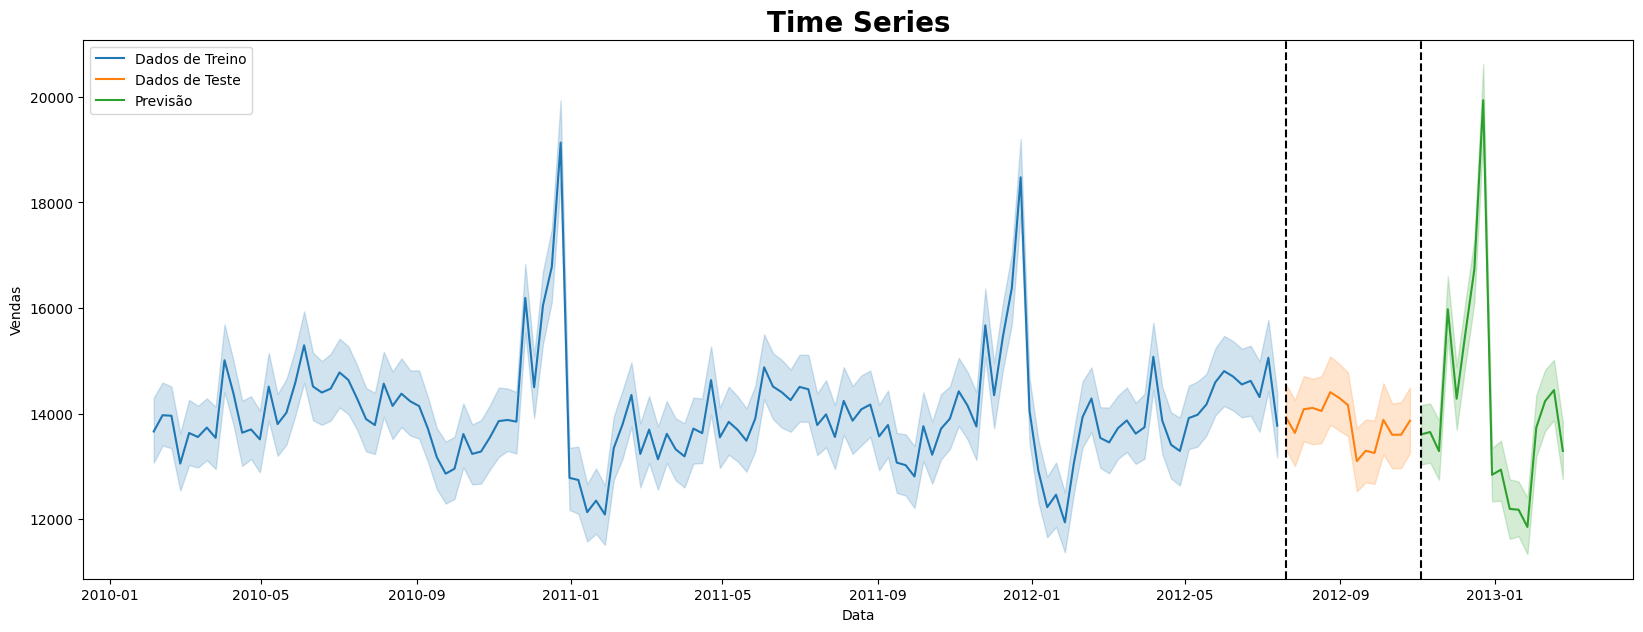

In [89]:
CUTOFF_DATE = '2012-07-20'
CUTOFF_DATE2 = '2012-11-04'
plot_time_series_split(train, test, df_new, CUTOFF_DATE, CUTOFF_DATE2)

#### Relatório Financeiro

In [90]:
final_financial_results = df_new.copy().reset_index()[['Date', 'Store', 'Dept', 'Previsto']]
final_financial_results['Previsto'] = final_financial_results['Previsto'].round(2)
final_financial_results['Margem Erro p/ Baixo'] = final_financial_results['Previsto'] - weekly_mae
final_financial_results['Margem Erro p/ Cima'] = final_financial_results['Previsto'] + weekly_mae
final_financial_results.to_excel('../data/output/financial_results.xlsx', index=False)
final_financial_results

,Date,Store,Dept,Previsto,Margem Erro p/ Baixo,Margem Erro p/ Cima
0,2012-11-04,1,1,35525.61,33894.01,37157.21
1,2012-11-11,1,1,18033.64,16402.04,19665.24
2,2012-11-18,1,1,18154.28,16522.68,19785.88
3,2012-11-25,1,1,19869.31,18237.71,21500.91
4,2012-12-02,1,1,23632.00,22000.40,25263.60
...,...,...,...,...,...,...
72670,2013-01-27,45,95,47888.30,46256.70,49519.90
72671,2013-02-03,45,95,53436.52,51804.92,55068.12
72672,2013-02-10,45,95,51183.23,49551.63,52814.83
72673,2013-02-17,45,95,49745.24,48113.64,51376.84


In [91]:
# Agrupando por Loja
mean_sales_stores = final_financial_results.groupby(['Date', 'Store'])[['Previsto', 'Margem Erro p/ Baixo', 'Margem Erro p/ Cima']].mean().round(2).reset_index()
mean_sales_stores.to_excel('../data/output/mean_sales_stores.xlsx', index=False)
mean_sales_stores

,Date,Store,Previsto,Margem Erro p/ Baixo,Margem Erro p/ Cima
0,2012-11-04,1,19019.26,17387.66,20650.86
1,2012-11-04,2,22414.79,20783.19,24046.39
2,2012-11-04,3,5372.55,3740.95,7004.15
3,2012-11-04,4,24485.75,22854.15,26117.35
4,2012-11-04,5,4896.97,3265.37,6528.57
...,...,...,...,...,...
760,2013-02-24,41,15158.98,13527.38,16790.58
761,2013-02-24,42,6997.76,5366.16,8629.36
762,2013-02-24,43,7980.03,6348.43,9611.63
763,2013-02-24,44,4258.11,2626.51,5889.71


### Conclusão

O modelo de machine Learning LightGBM construído captou a tendência de vendas nos feriados de Ação de Graças e Natal e a queda no início do ano, apresentando uma boa performance.<br>
O Erro do modelo está em torno de 1631.59 unidades de venda. A média de vendas é cerca de 15981.25.<br>
A criação da margem de erro garante o acerto em 71% das previsões.
